In [2]:
# import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

Using TensorFlow backend.


# Model
* Using a transferlearning to speed up training and reduce the amount of data required
* Using a native keras implementation of VGG16 https://arxiv.org/abs/1409.1556

![alt text](images/A-schematic-of-the-VGG-16-Deep-Convolutional-Neural-Network-DCNN-architecture-trained.png)


In [3]:
def transferlearning_model(input_shape):
    # build the VGG16 network
    VGGmodel = applications.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)
    print('Model loaded.')

    model = Sequential()
    for layer in VGGmodel.layers: 
        model.add(layer)

    model.add(Flatten())
    model.add(Dense(256, activation='relu', name="final_feature_collection"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', name="final_decision"))


    return model

In [3]:
def train_model(input_weights=None, output_weights=None, lr=1e-2, 
                epochs=5, train_row=set()):
    
    train_data_dir='data/train'
    validation_data_dir='data/val'
    img_width=150
    img_height=150
    nb_train_samples = 6000
    nb_validation_samples = 1000
    batch_size = 16

    model = transferlearning_model((img_width, img_height, 3))

    # # add the model on top of the convolutional base
    # model.add(top_model)

    # set the only the final layers to be trained
    # to non-trainable (weights will not be updated)
 
    train_by_name = []
    block_base = ['_conv1', '_conv2', '_conv3', '_pool']
    for row in train_row:
        block_list = ['block'+str(row)+ending for ending in block_base]
        train_by_name += block_list

    train_by_name += ['final_feature_collection', 'final_decision', 'flatten_1', 'dropout_1']

    for i_layer, layer in enumerate(model.layers):
        if layer.name in train_by_name:
            layer.trainable = True
        else:
            layer.trainable = False
        print(layer.name, layer.trainable)
    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    if input_weights is not None:
        model.load_weights(input_weights, by_name=True)

    print(model.summary)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(lr=lr, momentum=0.9),
                  metrics=['accuracy'])

    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

    # fine-tune the model
    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

    if output_weights is not None:
        model.save(output_weights)

In [4]:
lr = 1e-3# ???
train_list = []# ???
train_model(input_weights=None, output_weights='weights/stage_dummy.h5', lr=lr, 
            epochs=1, train_row=train_list)

Instructions for updating:
Colocations handled automatically by placer.
Model loaded.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten_1 True
final_feature_collection True
dropout_1 True
final_decision True
<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7fbe85ddca58>>
Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
375/375 [==============================] - 66s 175ms/step - loss: 0.4605 - acc: 0.7742 - val_loss: 0.3280 - val_acc: 0.8468


OSError: Unable to create file (unable to open file: name = 'weights/stage_dummy.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [4]:
def get_prediction_model(weight_path, img_width, img_height):

    model = transferlearning_model((img_width, img_height, 3))

    model.load_weights(weight_path, by_name=True)

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(lr=0.01, momentum=0.9),
                  metrics=['accuracy'])
    return model

In [6]:
test_data_dir = 'data/test'
img_width=150
img_height=150
nb_test_samples = 2000
batch_size = 1

model = get_prediction_model('weights/stage_3.h5', img_width, img_height)

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Instructions for updating:
Colocations handled automatically by placer.
Model loaded.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Found 2000 images belonging to 2 classes.


# Test the model
Look at `model.evaluate_generator`

In [1]:
score = model.evaluate_generator(test_generator, nb_test_samples/batch_size)

print("Test loss     : {}".format(score[0]))
print("Test accuracy : {}".format(score[1]))

NameError: name 'model' is not defined

# Check the errors
Is there anything we can do?

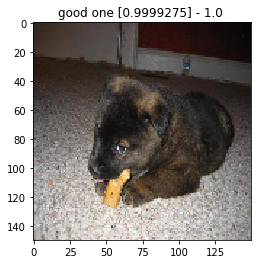

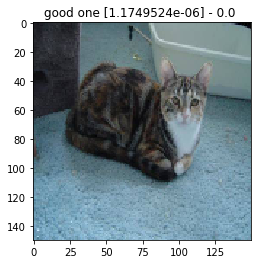

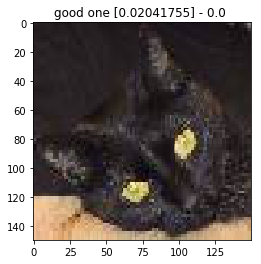

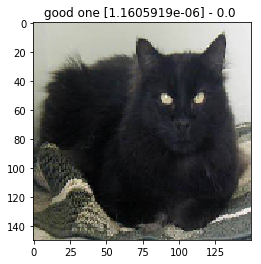

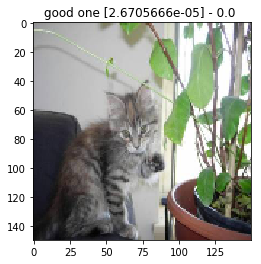

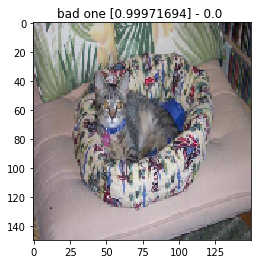

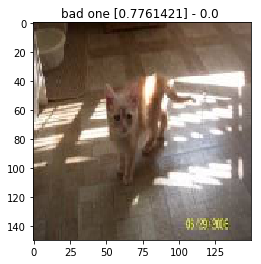

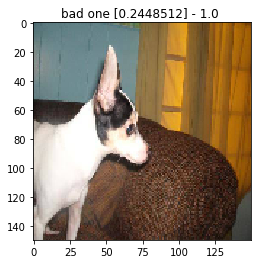

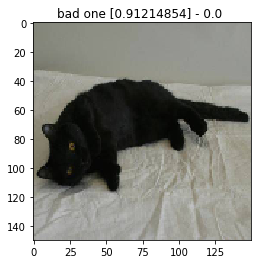

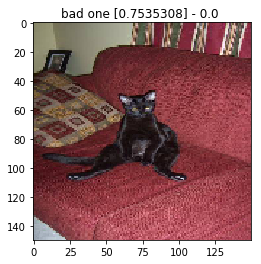

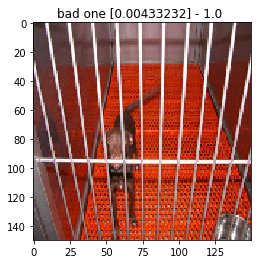

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

good_count = 0
good_list = []
bad_count = 0
bad_list = []
n_show = 5

for i_batch in range(nb_test_samples):
    X, y = test_generator.__getitem__(i_batch)
    y_pred = model.predict(X)

    if abs(y_pred[0][0]-y[0]) < 0.5:
        if good_count < n_show:
            good_list.append((X[0], y_pred[0], y[0]))
            good_count += 1
    else:
        if bad_count > n_show:
            break
        else:
            bad_list.append((X[0], y_pred[0], y[0]))
            bad_count += 1

# show some good ones
for X, y_pred, y in good_list:
    plt.figure()
    plt.imshow(X)
    plt.title("good one {y_pred} - {y} ".format(y_pred=y_pred, y=y))
plt.show()

# show and bad ones

for X, y_pred, y in bad_list:
    plt.figure()
    plt.imshow(X)
    plt.title("bad one {y_pred} - {y} ".format(y_pred=y_pred, y=y))
plt.show()


# Make a prediction
Make a function that will take a `jpg` and return a prediction. It must check the do the same to the data that we did when we trained it.

# Call my API to see if you have a cat or a dog
Use the command line tool `curl`.

# Try to see if the model is interperatable
We use LIME https://arxiv.org/pdf/1602.04938.pdf

We could make an entire lecture on this so I definetly recomend reading the paper!

In [8]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [9]:
explainer = lime_image.LimeImageExplainer()

In [10]:
def evaluate_model(image):
    return model.predict(image)

In [11]:
print(evaluate_model(good_list[0][0].reshape(1,150,150,3))) # here

[[0.9999275]]


In [30]:
explanation = explainer.explain_instance(good_list[0][0], evaluate_model, top_labels=1, hide_color=0, 
                                         num_samples=3000)

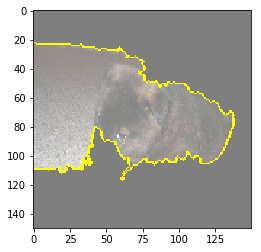

In [31]:
temp, mask = explanation.get_image_and_mask(0, positive_only=True, num_features=3, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [17]:
explanation = explainer.explain_instance(bad_list[0][0], evaluate_model, top_labels=1, hide_color=0, 
                                         num_samples=1000)

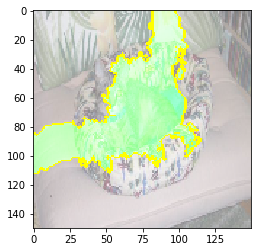

In [24]:
temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))